In [2]:
# Imports
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,  precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance
from sklearn.metrics import plot_confusion_matrix

# Google Colab Auth - only needed for colab

In [2]:
'''
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''

In [3]:
#df = drive.CreateFile({'id': '1GeNGKsWNsDR2jS5V5kMADGxBMZz3jH8K'})
#df.GetContentFile('notime_df.csv')

# If working in regular jupyter notebook

In [38]:
df = pd.read_csv('../data/no_time.csv')

In [39]:
print("Dataset has {} entries and {} features".format(*df.shape))

Dataset has 127193 entries and 16 features


In [32]:
# Check for NaN values
df.isna().sum()

Stn Id                  0
ETo (in)                0
Precip (in)             0
Sol Rad (Ly/day)        0
Avg Vap Pres (mBars)    0
Max Air Temp (F)        0
Min Air Temp (F)        0
Avg Air Temp (F)        0
Max Rel Hum (%)         0
Min Rel Hum (%)         0
Avg Rel Hum (%)         0
Dew Point (F)           0
Avg Wind Speed (mph)    0
Wind Run (miles)        0
Avg Soil Temp (F)       0
Target                  0
dtype: int64

In [33]:
df

,Stn Id,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127188,262,0.11,0.00,306.0,14.0,82.5,53.2,64.9,95.0,33.0,67.0,53.6,2.6,63.1,70.6,1
127189,262,0.07,0.00,245.0,15.4,77.1,52.4,63.5,96.0,52.0,77.0,56.2,2.3,54.8,69.7,1
127190,262,0.13,0.00,412.0,15.8,85.1,50.6,65.4,97.0,39.0,74.0,56.9,2.1,49.8,69.4,1
127191,262,0.10,0.00,338.0,16.7,83.2,50.6,65.0,97.0,46.0,79.0,58.4,1.6,38.8,69.2,1


# Initial model comparisons

Note: classes remain imbalanced

In [40]:
class Fire(object):
    def __init__(self, df):
        self.y = df.pop('Target')
        self.X = df

    def split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, stratify=self.y)

    def predict(self, model):
        self.model = model
        kf = KFold(n_splits=5)
        
        accuracy = []
        precision = []
        recall = []
        f1 = []

        for train_index, test_index in kf.split(self.X_train):
            X_train_split, X_test_split = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_split, y_test_split = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
            self.model.fit(X_train_split, y_train_split, verbose=True)
            self.pred = self.model.predict(X_test_split)

            assess = lambda method, val=y_test_split, pred=self.pred: method(val, pred)

            accuracy.append(assess(accuracy_score))
            precision.append(assess(precision_score))
            recall.append(assess(recall_score))
            f1.append(assess(f1_score))
        
        return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1)
      
    def get_rates(self):
        self.proba = self.model.predict_proba(self.X_test)
        self.proba = self.proba[:,1]
        self.fpr, self.tpr, self.thresholds = roc_curve(self.y_test, self.proba)
        self.auc = auc(self.fpr, self.tpr)

        return self.fpr, self.tpr, self.auc

    def cm(self):
        return plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap=plt.cm.Purples , normalize='true')
    
    def plot_roc(self, ax, model):
        if model == 'knn':
          ax.plot(self.fpr, self.tpr, color='orange', label=f'{model}: {self.auc}')
          return ax
        elif model == 'forest':
          ax.plot(self.fpr, self.tpr, color='green', label=f'{model}: {self.auc}')
          return ax
        elif model == 'boost1':
          ax.plot(self.fpr, self.tpr, color='red', label=f'{model}: {self.auc}')
          return ax
        else:
          ax.plot(self.fpr, self.tpr, color='purple', label=f'{model}: {self.auc}')
          return ax

    def plot_importance(self):
        return plot_importance(self.model, max_num_features=15)

In [41]:
knn = KNeighborsClassifier()
forest = RandomForestClassifier()
boost = XGBClassifier()

# K Nearest Neighbors
data_knn = Fire(df)
data_knn.split()
data_knn.predict(knn)
data_knn.get_rates()
'''
data_knn.cm()
plt.title('K Nearest Neighbors Confusion Matrix')
plt.grid(False)
plt.savefig('knn_cm.jpeg')
plt.show()
'''
df = pd.read_csv('no_time.csv')

# Random Forest
data_forest = Fire(df)
data_forest.split()
data_forest.predict(forest)
data_forest.get_rates()
'''
data_forest.cm()
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.savefig('forest_cm.jpeg')
plt.show()
'''
df = pd.read_csv('no_time.csv')

# XGBoost
data_boost = Fire(df)
data_boost.split()
data_boost.predict(boost)
data_boost.get_rates()
'''
data_boost.cm()
plt.title('XGBoost Confusion Matrix')
plt.grid(False)
plt.savefig('boost_cm.jpeg')
plt.show()

# Feature Importances
data_boost.plot_importance()
plt.savefig('feature_importances.jpeg')
plt.show()
'''
# ROC CURVE
fig, ax = plt.subplots(figsize=(10,10))
data_knn.plot_roc(ax, model='knn')
data_forest.plot_roc(ax, model='forest')
data_boost.plot_roc(ax, model='boost')
ax.set_title('ROC Curves')
ax.plot([0,1], [0,1], color ='k', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
plt.savefig('../images/mb_forest_roc_curves_first_NEW.jpeg')
fig.show()

'''
# Compare to results on previous dataset
fig, ax = plt.subplots(figsize=(10,10))
data_boost.plot_roc(ax, model='boost1')
data_boost2.plot_roc(ax, model='boost2')
ax.set_title('ROC Curves')
ax.plot([0,1], [0,1], color ='k', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
plt.savefig('boost_comparison_roc.jpeg')
fig.show()

# Feature Importances
data_boost.plot_importance()
plt.savefig('feature_importances.jpeg')
plt.show()
'''

FileNotFoundError: [Errno 2] File notime_df.csv does not exist: 'notime_df.csv'

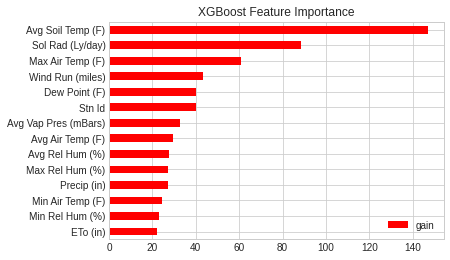

In [ ]:
feature_important = boost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by ="gain", ascending=True)
data.plot(kind='barh', color='r')
plt.title('XGBoost Feature Importance')
plt.show()

# Grid Search XGBoost


In [ ]:
# Grid Search XGBoost
# Ran in EC2 instance
'''
parameter_grid = {
                    'max_depth': [3, 9],
                    'n_estimators': [100, 900], 
                    'learning_rate': [0.01, 0.1],
                    'lambda': [0.5, 0.8], # l2 regualrization
                    'alpha': [0.25, 0.5]  # l1 regularization
                    }
clf = GridSearchCV(xgb.XGBClassifier(), parameter_grid, verbose= 1, scoring='recall', n_jobs=-1)
'''

In [42]:
df = pd.read_csv('../data/no_time.csv')

In [43]:
y = df.pop('Target')

# Weight the imbalanced dataset

In [47]:
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 24.262


## Compare weighted estimates and default XGBoost with Hypertuned XGBoost

In [48]:
params = {'max_depth': 10,
          'min_child_weight': 6,
          'n_estimators': 1000, 
          'learning_rate': 0.01,
          'lambda': 0.8,
          'alpha': 0.5}

In [50]:
boost1 = XGBClassifier(scale_pos_weight=estimate)
boost2 = XGBClassifier(**params, scale_pos_weight=estimate)

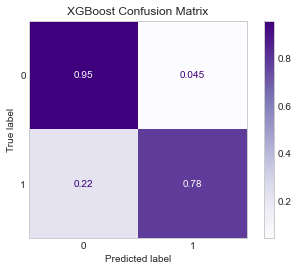

In [53]:
# df = pd.read_csv('../data/no_time.csv')

# data_boost1 = Fire(df)
# data_boost1.split()
# data_boost1.predict(boost1)
# data_boost1.get_rates()

# df = pd.read_csv('../data/no_time.csv')

# data_boost2 = Fire(df)
# data_boost2.split()
# accuracy, precision, recall, f1 = data_boost2.predict(boost2)
# data_boost2.get_rates()

data_boost2.cm()

plt.title('XGBoost Confusion Matrix')
plt.grid(False)
#plt.savefig('boost_cm.jpeg')
plt.show()


In [55]:
nl = '\n'
print(f'Accuracy: {round(accuracy,2)}{nl}Precision: {round(precision,2)}{nl}Recall: {round(recall, 2)}')

Accuracy: 0.95
Precision: 0.43
Recall: 0.77


In [8]:
# Save this hypertuned boost!
import pickle
pickle.dump(boost2, open('xgboost_model', 'wb'))

In [ ]:
# Compare to results on previous dataset
fig, ax = plt.subplots(figsize=(10,10))
data_boost1.plot_roc(ax, model='boost1')
data_boost2.plot_roc(ax, model='boost2')
ax.set_title('ROC Curves')
ax.plot([0,1], [0,1], color ='k', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
plt.savefig('boost_comparison_roc.jpeg')
fig.show()


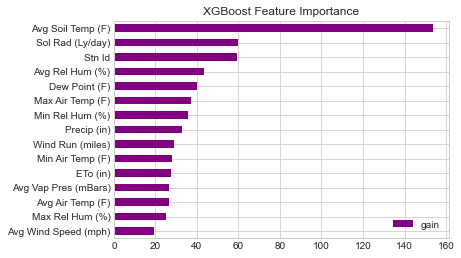

In [31]:
# Feature Importances
feature_important = boost2.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by ="gain", ascending=True)
data.plot(kind='barh', color='purple')
plt.title('XGBoost Feature Importance')
plt.show()

# Some EDA

In [6]:
from sklearn.inspection import plot_partial_dependence

In [11]:
y = df.pop('Target')

In [10]:
boost = pickle.load(open("../models/xgboost_model", "rb"))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

In [23]:
features = ['Avg Soil Temp (F)', 'Sol Rad (Ly/day)', ('Avg Soil Temp (F)', 'Sol Rad (Ly/day)')]

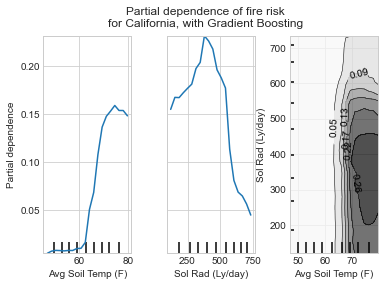

In [24]:
plot_partial_dependence(boost, X_train, features, n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of fire risk\n'
             'for California, with Gradient Boosting')
fig.subplots_adjust(wspace=0.4, hspace=0.3)